In [1]:
try:
    _=!git clone https://github.com/p-koo/tfomics.git
except:
    pass

In [2]:
import os, h5py, pandas as pd, sys
import numpy as np
srcpath = os.path.join(os.getcwd(), '..')
sys.path.append(srcpath)
import src
from src.layers import MultiHeadDense, MultiHeadAttention, PairwiseConv1D, NearestNeighborConv1D
from src.regularizers import PairwiseKernelRegularizer, NearestNeighborKernelRegularizer
custom_objects_dict = {'MultiHeadDense':MultiHeadDense,
                      'MultiHeadAttention':MultiHeadAttention,
                      'PairwiseConv1D':PairwiseConv1D,
                      'NearestNeighborConv1D':NearestNeighborConv1D,
                      'PairwiseKernelRegularizer':PairwiseKernelRegularizer,
                       'NearestNeighborKernelRegularizer':NearestNeighborKernelRegularizer}

import tensorflow as tf
from tensorflow import keras as tfk

from tfomics import moana, impress

from paramiko import SSHClient
from scp import SCPClient

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Collect results from local

In [3]:
EXPT_DIRNAME = "cnn_att_encode_chipseq"
POOL_SIZE=20
EXPT_DIRNAME = os.path.join(EXPT_DIRNAME, "max_pool_%d"%POOL_SIZE)
RESULTSDIR = os.path.join(os.getcwd(), '..', 'results', EXPT_DIRNAME)  ## local path
tfids = os.listdir(RESULTSDIR)

reg_test_metrics_df = {'TFID':[],  'loss':[], 'ACC':[], 'AUROC':[], 'AUPR':[]}
pairwise_test_metrics_df = {'TFID':[], "l1":[], 'loss':[], 'ACC':[], 'AUROC':[], 'AUPR':[]}
nn_test_metrics_df = {'TFID':[], "l1":[], 'loss':[], 'ACC':[], 'AUROC':[], 'AUPR':[]}

for tfid in tfids:
    #print("Collecting results for TF : %s ..."%tfid)
    tfid_dir = os.path.join(RESULTSDIR, tfid)
    
    # get regular conv results 
    reg_test_metrics_df['TFID'].append(tfid)
    reg_dir = os.path.join(tfid_dir, "regular_conv_results")
    reg_path = os.path.join(reg_dir, "test_metrics.csv")
    df=pd.read_csv(reg_path, index_col=[0])
    names = df.Metric.values
    values = df.Value.values
    for name, value in zip(names, values):
        reg_test_metrics_df[name].append(value)
    # get pairwise conv results 
    pairwise_dir = os.path.join(tfid_dir, "pairwise_conv_results")
    for i, l1folder in enumerate(os.listdir(pairwise_dir)):
        pairwise_test_metrics_df['TFID'].append(tfid)
        pairwise_test_metrics_df['l1'].append(str(l1folder).split("=")[-1])
        fname = os.path.join(pairwise_dir, l1folder, "test_metrics.csv")
        df=pd.read_csv(fname, index_col=[0])
        names = df.Metric.values
        values = df.Value.values
        for name, value in zip(names, values):
            pairwise_test_metrics_df[name].append(value)
    
    # get nearest neighbor conv results 
    nn_dir = os.path.join(tfid_dir, "nearest_neighbor_conv_results")
    for i, l1folder in enumerate(os.listdir(nn_dir)):
        nn_test_metrics_df['TFID'].append(tfid)
        nn_test_metrics_df['l1'].append(str(l1folder).split("=")[-1])
        fname = os.path.join(nn_dir, l1folder, "test_metrics.csv")
        df=pd.read_csv(fname, index_col=[0])
        names = df.Metric.values
        values = df.Value.values
        for name, value in zip(names, values):
            nn_test_metrics_df[name].append(value)
    
    
    # get nearest neighbor conv results 
    tfid_nn_dir = os.path.join(tfid_dir, "nearest_neighbor_conv_results")

reg_test_metrics_df = pd.DataFrame(reg_test_metrics_df).sort_values(by='TFID')
pairwise_test_metrics_df = pd.DataFrame(pairwise_test_metrics_df).sort_values(by='TFID')
nn_test_metrics_df = pd.DataFrame(nn_test_metrics_df).sort_values(by='TFID')
highorder_conv_test_metrics = {'pairwise':pairwise_test_metrics_df, 'nearest neighbor':nn_test_metrics_df}
metric_names = list(reg_test_metrics_df.columns[-3:])

In [212]:
# tfids with n largest AUROCs
topauroc_subset = reg_test_metrics_df.nlargest(n=5, columns=['AUROC'])
topauroc_tfids = topauroc_subset.TFID.values

# take the 1st tfid from above list 
tfid = topauroc_tfids[0]

In [214]:
# get the best l1 factors for the corresponding tfid
nnl1 = nn_test_metrics_df[nn_test_metrics_df['TFID']==tfid].nlargest(n=1, \
                                                         columns="AUROC").l1.values[0]
nnl1 = float(nnl1)
pairwisel1 = pairwise_test_metrics_df[pairwise_test_metrics_df['TFID']==tfid].nlargest(n=1,\
                                                          columns="AUROC").l1.values[0]
pairwisel1 = float(pairwisel1)
pairwisel1 = 1e-1
nnl1 = 1e-1

In [215]:
# download the regular model for the above tfid 
username, hostname = os.getenv('BAMDEV1').split("@")
ssh = SSHClient()
ssh.load_system_host_keys()
ssh.connect(hostname=hostname, username=username)
remotehome = ssh.exec_command("echo $HOME")[1].readlines()[0].strip()
scp = SCPClient(ssh.get_transport())
REMOTEDIR = os.path.join(remotehome, "projects/higher_order_convolutions_full/results", EXPT_DIRNAME)
REMOTEDATADIR = os.path.join(remotehome, "projects/higher_order_convolutions", 'data', 'deepbind_encode_chipseq')

remote_tfid_dir = os.path.join(REMOTEDIR, tfid)
reg_results_dir = os.path.join(remote_tfid_dir, 'regular_conv_results')
nn_results_dir = os.path.join(remote_tfid_dir, 'nearest_neighbor_conv_results',\
                             'l1={:.0e}'.format(nnl1))
pairwise_results_dir = os.path.join(remote_tfid_dir, 'pairwise_conv_results',\
                                    'l1={:.0e}'.format(pairwisel1))
best_reg_model_path = os.path.join(reg_results_dir, "best_model.hdf5")
best_pairwise_model_path = os.path.join(pairwise_results_dir, "best_model.hdf5")
best_nn_model_path = os.path.join(nn_results_dir, "best_model.hdf5")

# download and load the standard conv model 
print("Downloading regular conv model ...")
scp.get(remote_path=best_reg_model_path)
print("Loading regular conv model ...")
with tfk.utils.CustomObjectScope(custom_objects_dict):
    reg_model = tfk.models.load_model("best_model.hdf5")
!rm best_model.hdf5

# download and load the pairwise conv model 
print("Downloading pairwise conv model ...")
print(best_pairwise_model_path)
scp.get(remote_path=best_pairwise_model_path)
print("Loading pairwise conv model ...")
with tfk.utils.CustomObjectScope(custom_objects_dict):
    pairwise_model = tfk.models.load_model("best_model.hdf5")
!rm best_model.hdf5

# download and load the NN conv model 
print("Downloading nearest neighbor conv model ...")
scp.get(remote_path=best_nn_model_path)
print("Loading nearest neighbor conv model ...")
with tfk.utils.CustomObjectScope(custom_objects_dict):
    nn_model = tfk.models.load_model("best_model.hdf5")
!rm best_model.hdf5

print("Downloading data ...")
if not os.path.exists("data.h5"):
    scp.get(remote_path=os.path.join(REMOTEDATADIR, tfid, 'data.h5'))
print("Loading data ...")
data = h5py.File('data.h5', 'r')
x_train = data['X_train'][:]
y_train = data['Y_train'][:]
x_test = data['X_test'][:]
y_test = data['Y_test'][:]
if y_train.ndim == 1:
    y_train = y_train[:, None]
if y_test.ndim == 1:
    y_test = y_test[:, None]
data.close()
!rm data.h5

Loading regular conv model ...
/grid/koo/home/tripath/projects/higher_order_convolutions_full/results/cnn_att_encode_chipseq/max_pool_20/MAFF_K562_MafF_-M8194-_Stanford/pairwise_conv_results/l1=1e-01/best_model.hdf5
Loading pairwise conv model ...
Loading nearest neighbor conv model ...
Loading data ...


## plot 1st layer convolution filters 

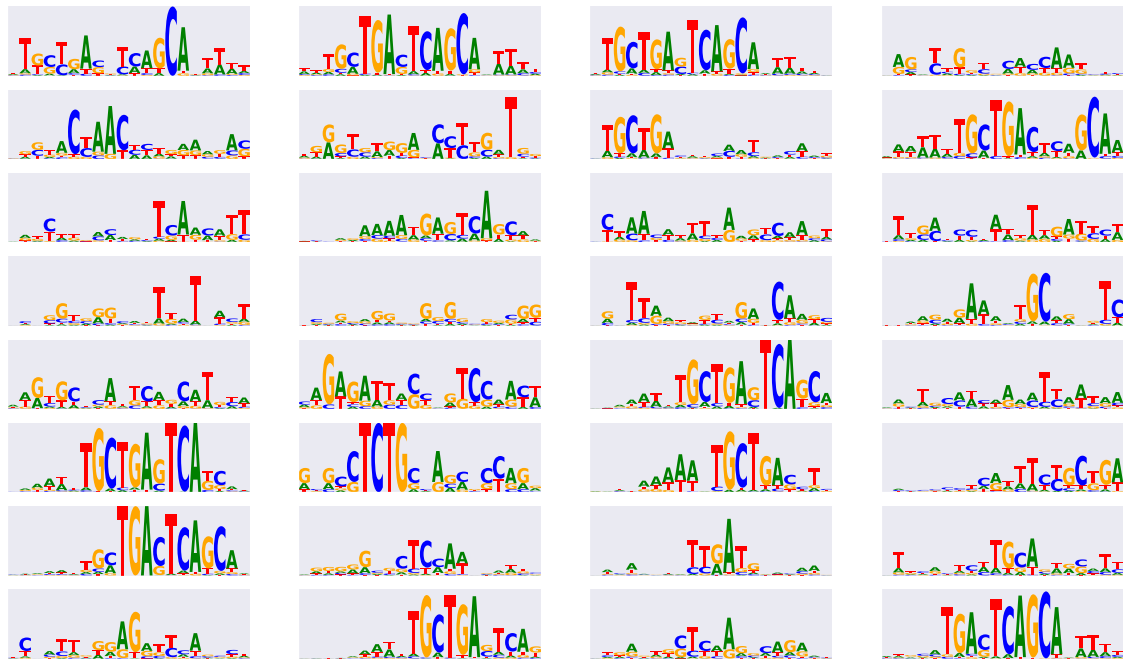

In [216]:
# plot forward filters for regular conv model 
fig = plt.figure(figsize=(20,12))
W_reg = moana.filter_activations(x_test, reg_model, layer=1, window=20, threshold=0.5)
impress.plot_filters(W_reg, fig, num_cols=4, alphabet='ACGT');

In [217]:
pairwise_conv_layer = pairwise_model.layers[1]
pkern = tf.transpose(pairwise_conv_layer.full_kernel, [2, 0, 1])
pkern_diag = tf.linalg.diag_part(pkern)
pkern_bias = tf.convert_to_tensor(pkern_bias.numpy())


def _get_patches(x):
    x = tf.expand_dims(x, 2)
    sizes = [1, pairwise_conv_layer.kernel_size[0], 1, 1]
    strides = [1, pairwise_conv_layer.strides[0], 1, 1]
    rates = [1, pairwise_conv_layer.dilation_rate[0], 1, 1]
    padding = pairwise_conv_layer.padding_map_dict[pairwise_conv_layer.padding]
    xp = tf.image.extract_patches(x,sizes=sizes,strides=strides,rates=rates,padding=padding)
    xp = tf.squeeze(xp, axis=2)  ## (N, num patches, flattened patch size)
    return xp

def _pairwise_diag_conv(x):
    xp = _get_patches(x)
    w = tf.transpose(pkern_diag, [1, 0])
    y = tf.einsum("ijk, kl -> ijl", xp, w) + pkern_bias
    return y

pairwise_diag_conv = tfk.layers.Lambda(_pairwise_diag_conv)
pairwise_diag_model = tfk.Sequential([tfk.layers.Input(x_test.shape[1:]), pairwise_diag_conv])

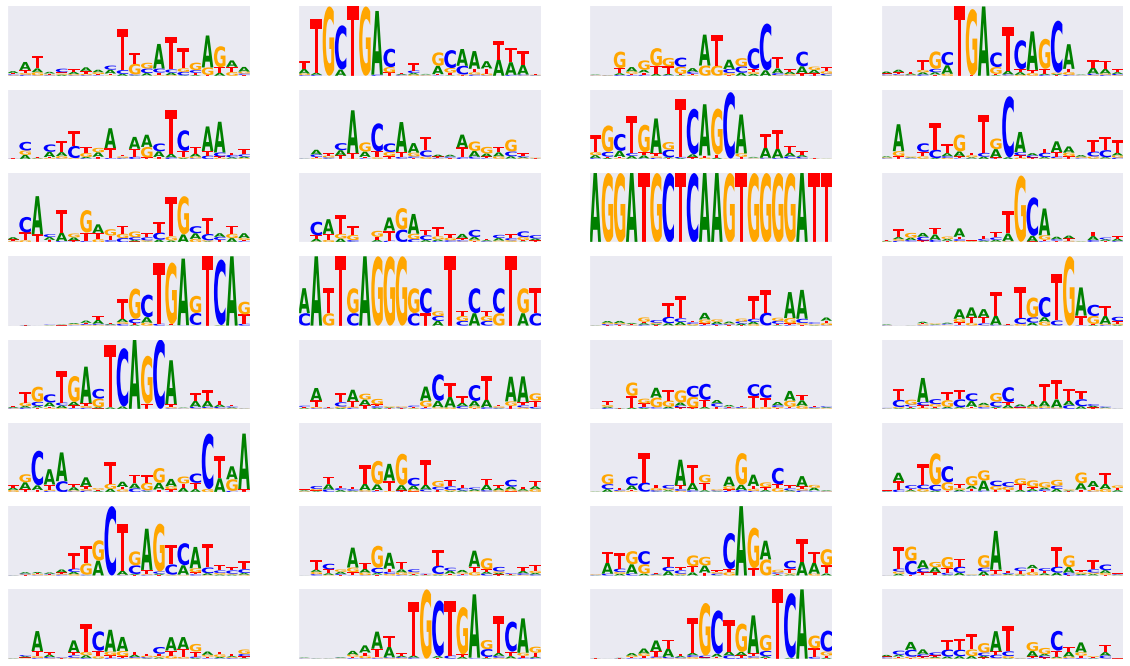

In [218]:
# plot forward filters for pairwise conv model  (diag components only)
fig = plt.figure(figsize=(20,12))
W_reg = moana.filter_activations(x_test, pairwise_diag_model, layer=0, window=20, threshold=0.5)
impress.plot_filters(W_reg, fig, num_cols=4, alphabet='ACGT');

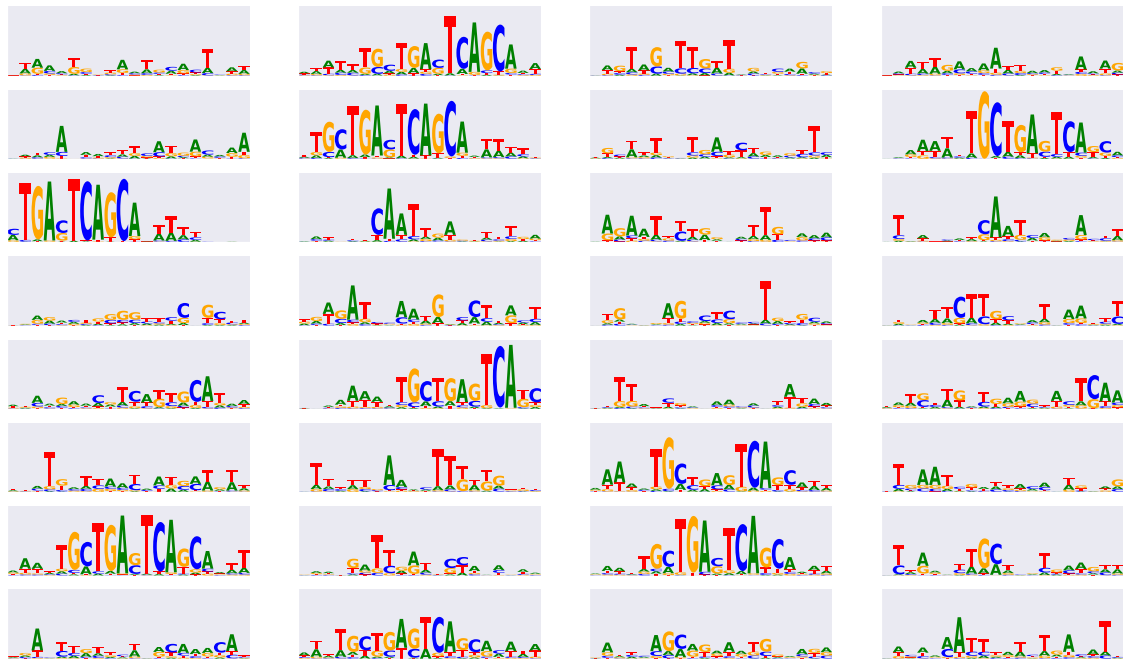

In [14]:
# plot forward filters for pairwise conv model 
fig = plt.figure(figsize=(20,12))
W_pairwise = moana.filter_activations(x_test, pairwise_model, layer=1, window=20, threshold=0.5)
impress.plot_filters(W_pairwise, fig, num_cols=4, alphabet='ACGT');

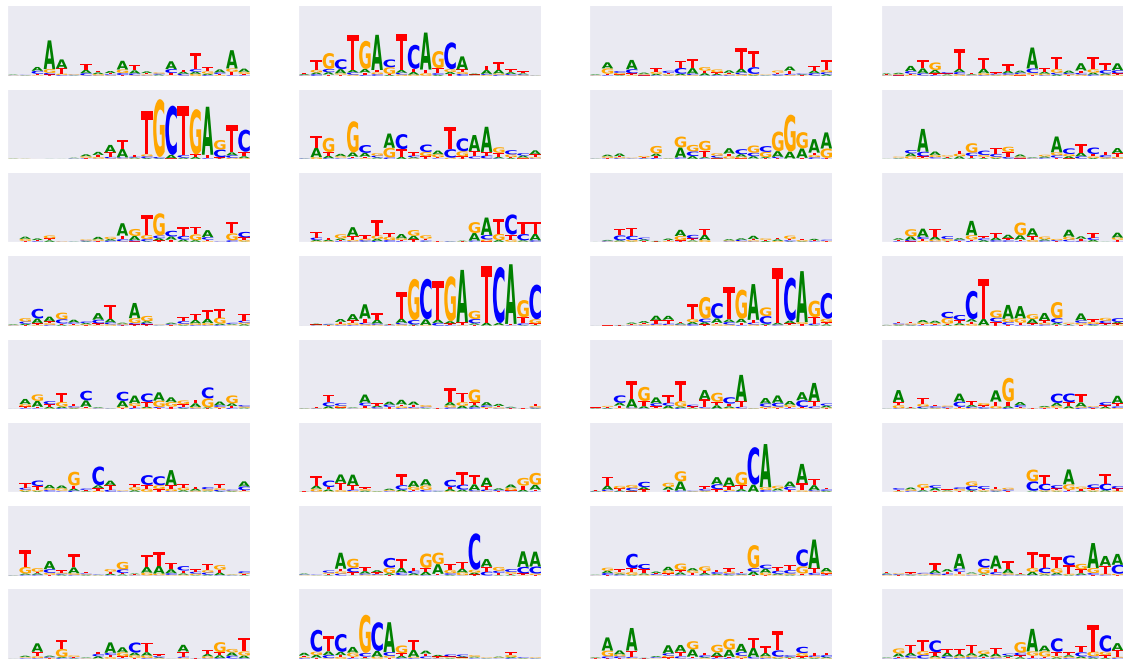

In [13]:
# plot forward filters for NN conv model 
fig = plt.figure(figsize=(20,12))
W_nn = moana.filter_activations(x_test, nn_model, layer=1, window=20, threshold=0.5)
impress.plot_filters(W_nn, fig, num_cols=4, alphabet='ACGT');

In [21]:
reg_kernel = tf.linalg.diag(tf.transpose(reg_model.layers[1].kernel, [1,2,0])).numpy()
nn_kernel = nn_model.layers[1].kernel.numpy().transpose((2, 3, 0, 1))
# pairwise_kernel = pairwise_model.layers[1].full_kernel.numpy().transpose((2, 3, 0, 1))

# kernel_size = nn_kernel.shape[-1]
# reg_mask = ~(np.eye(kernel_size) == True)
# nn_mask = np.eye(kernel_size) + np.diag(np.ones(kernel_size-1), k=1)
# nn_mask = ~(nn_mask == True)
# pairwise_mask = np.tril(np.ones((kernel_size, kernel_size)))
# pairwise_mask = ~(pairwise_mask == True)

# fig = plt.figure(figsize=(16, 13))
# gridspec = mpl.gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
# sns.heatmap(nn_kernel[0,0], mask=nn_mask, linewidth=1, cmap='viridis', ax=fig.add_subplot(gridspec[0, :2]));
# sns.heatmap(pairwise_kernel[0,0], linewidth=1, mask=pairwise_mask, cmap='viridis', ax=fig.add_subplot(gridspec[0, 2:4]));
# sns.heatmap(reg_kernel[0,0], linewidth=1,  mask=reg_mask, cmap='viridis', ax=fig.add_subplot(gridspec[1, 1:3]));

ValueError: axes don't match array

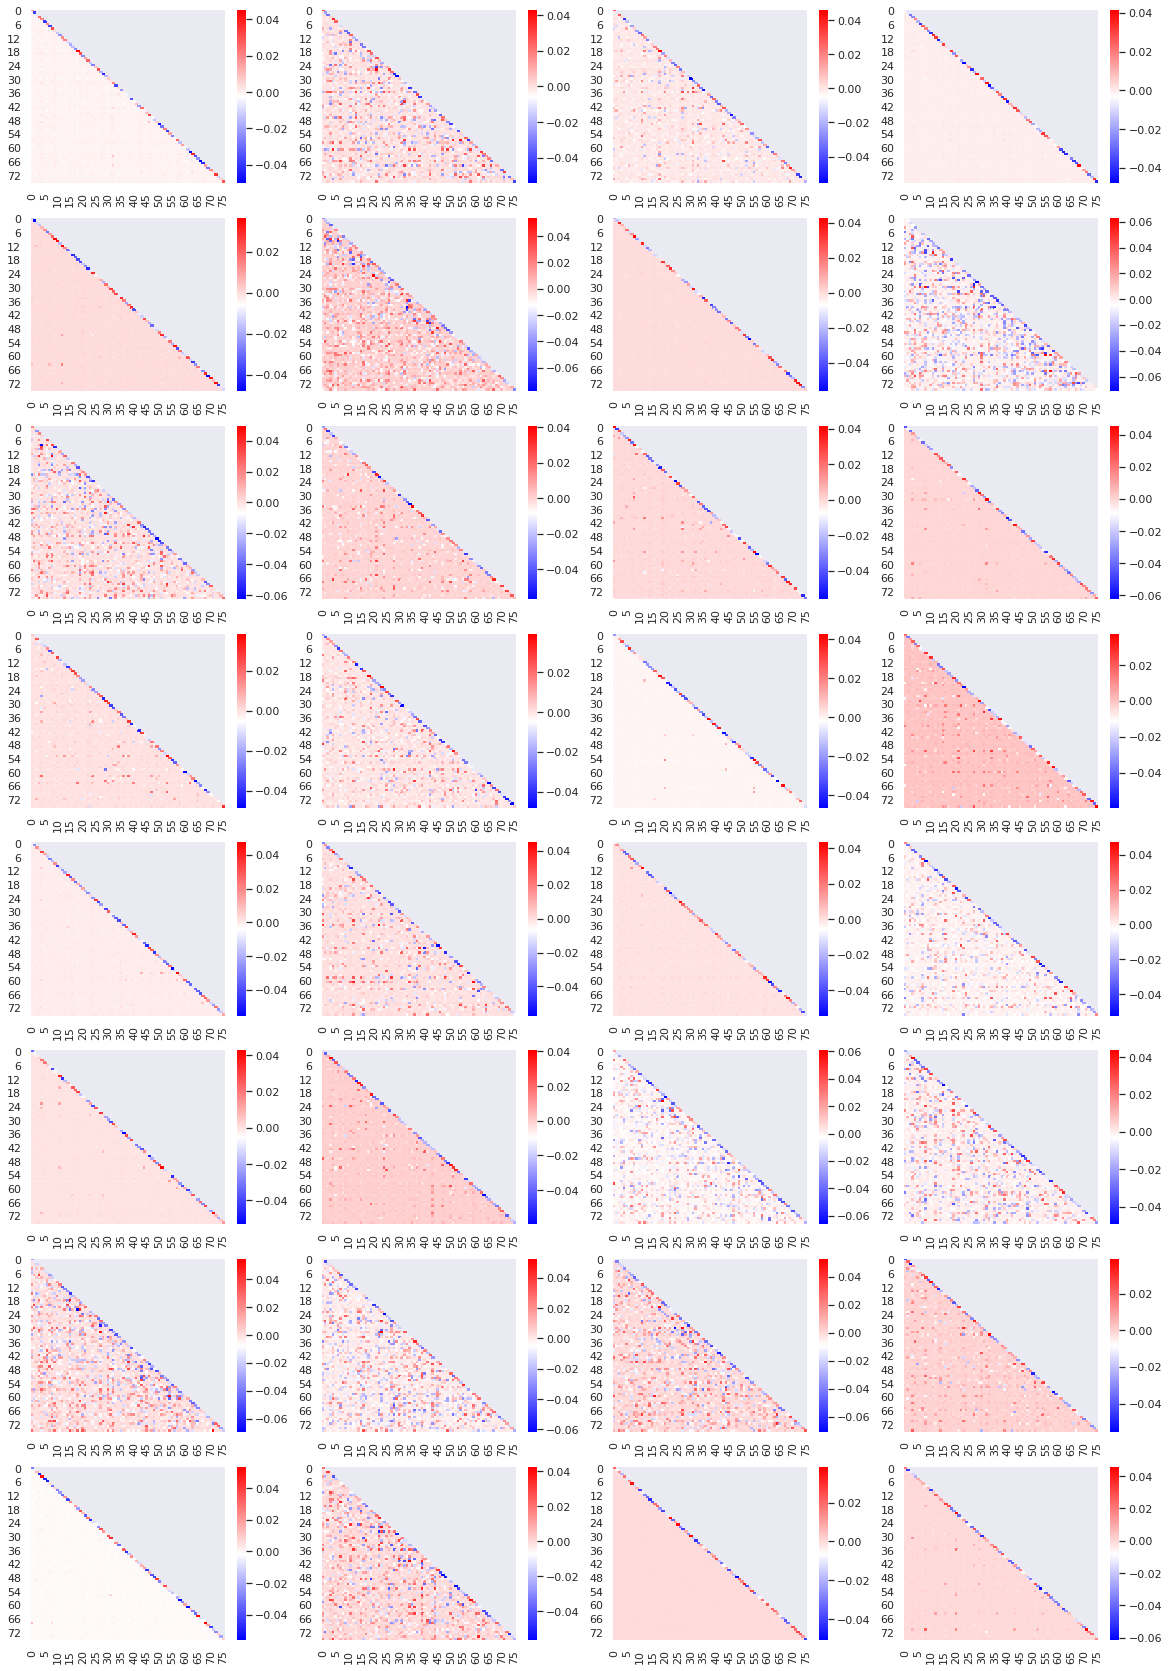

In [65]:
pkern = tf.transpose(pairwise_model.layers[1].full_kernel, [2, 0, 1]).numpy()
num_filters = pkern.shape[0]
mask = np.tril(np.ones((pkern.shape[1], pkern.shape[1]))).astype(bool)

fig, ax  = plt.subplots(8, 4, figsize=(20, 30))
idxs = [(i,j) for i in range(8) for j in range(4)]
for idx in idxs:
    i,j = idx
    sns.heatmap(pkern[4*i + j], cmap='bwr', mask=~mask, ax=ax[i,j])

(32, 76, 76)

In [56]:
pkern.shape[1]

76